In [1]:
!pip install -q split-folders

In [2]:
!pip install mlxtend

In [3]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import splitfolders
import glob

from PIL import Image


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

TensorFlow version: 2.4.1


## Flowers dataset overview

### Total number of images and by per category

In [4]:
path = '../input/flowers-recognition/flowers'
categories = os.listdir(path)

print('Total number of images:', sum([len(os.listdir(path + '/' + cat)) for cat in categories]))
print('\nFlowers categories:', len(categories), categories)
print('\nTotal number images by each category:')
print('Dandelion images:', len(os.listdir(path + '/dandelion')))
print('Daisy images:    ', len(os.listdir(path + '/daisy')))
print('Sunflower images:', len(os.listdir(path + '/sunflower')))
print('Tulip images:    ', len(os.listdir(path + '/tulip')))
print('Rose images:     ', len(os.listdir(path + '/rose')))

Total number of images: 4317

Flowers categories: 5 ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

Total number images by each category:
Dandelion images: 1052
Daisy images:     764
Sunflower images: 733
Tulip images:     984
Rose images:      784


### Resolution of the images

In [5]:
%%time

img_shapes = {"height": [], "width": []}

for cat in categories:
    filelist = glob.glob(path + '/' + cat + '/*.jpg')
    for fname in filelist:
        img_shapes["height"].append(np.array(Image.open(fname)).shape[0])
        img_shapes["width"].append(np.array(Image.open(fname)).shape[1])

CPU times: user 21.3 s, sys: 784 ms, total: 22.1 s
Wall time: 43.8 s


In [6]:
df_img_sizes = pd.DataFrame(img_shapes)
print(df_img_sizes.shape)
df_img_sizes.describe()

(4317, 2)


,height,width
count,4317.000000,4317.000000
mean,253.073662,338.379893
std,61.558205,119.067232
min,80.000000,134.000000
25%,214.000000,240.000000
50%,240.000000,320.000000
75%,329.000000,500.000000
max,442.000000,1024.000000


array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'width'}>]], dtype=object)

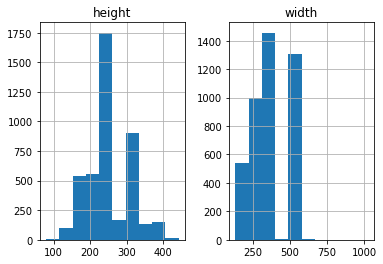

In [7]:
df_img_sizes.hist()

In [8]:
#Let's take the most popular resolutions according to the histogram
IMG_HEIGHT = 240
IMG_WIDTH = 260

In [9]:
def draw_flowers(category):
    rose_dir = path + '/' + category
    rose_files = os.listdir(path + '/' + category)

    # Output images in a 4x4 configuration
    nrows = 4
    ncols = 4
    pic_index = 8


    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    next_rose_img = [os.path.join(rose_dir, fname) 
                    for fname in rose_files[:pic_index]]

    for i, img_path in enumerate(next_rose_img):
      sp = plt.subplot(nrows, ncols, i + 1)
      sp.axis('Off')

      img = mpimg.imread(img_path)
      plt.imshow(img)

    plt.show()

### Dandelion

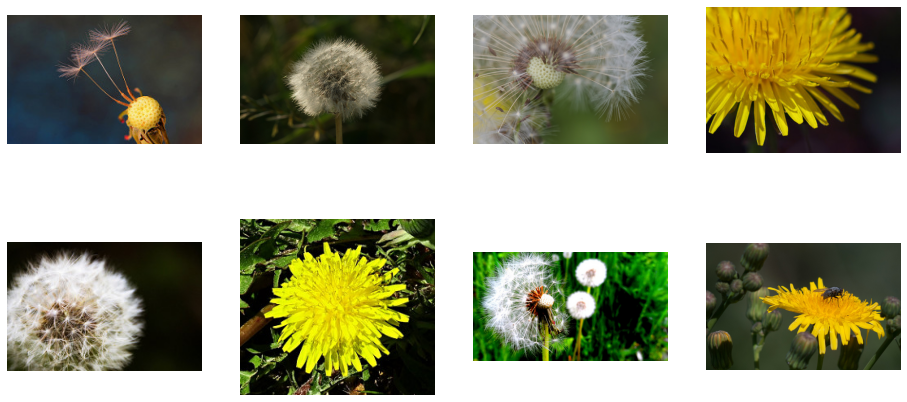

In [10]:
draw_flowers('dandelion')

### Daisy

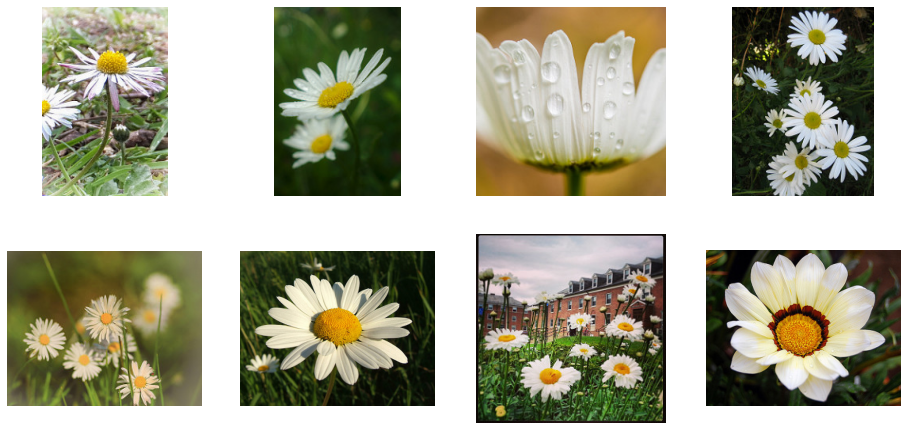

In [11]:
draw_flowers('daisy')

### Sunflower

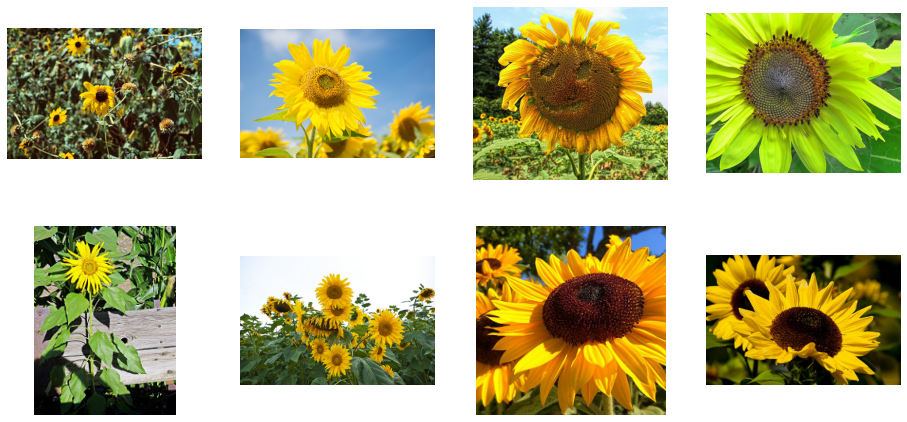

In [12]:
draw_flowers('sunflower')

### Tulip

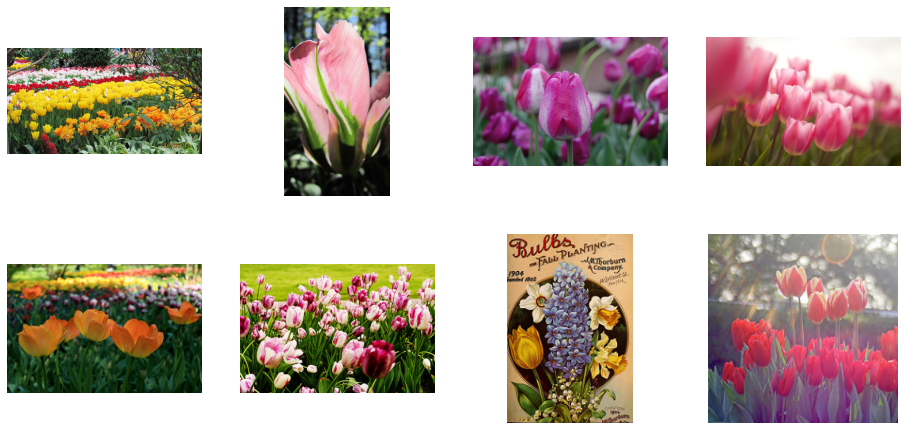

In [13]:
draw_flowers('tulip')

### Rose

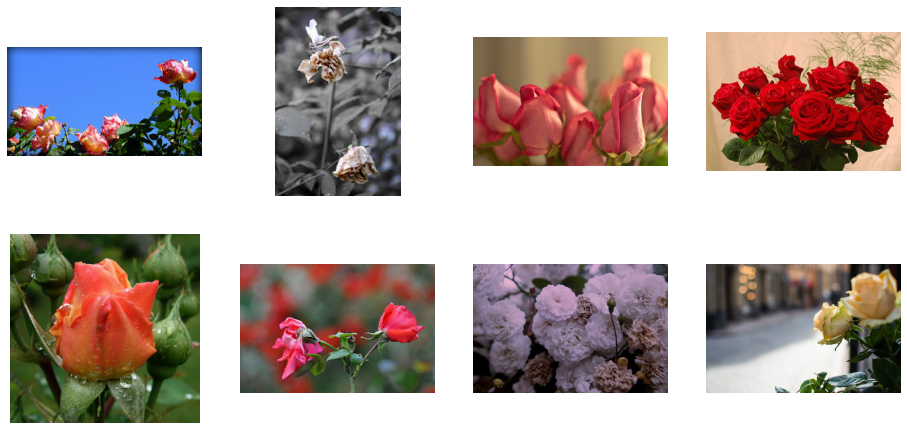

In [14]:
draw_flowers('rose')

## Split data into train, validation and test sets

In [15]:
splitfolders.ratio(path, output="output", seed=100, ratio=(.6, .2, .2), group_prefix=None)

Copying files: 4317 files [00:04, 1069.05 files/s]


In [16]:
path_train = 'output/train/'
path_valid = 'output/val/'
path_test = 'output/test/'
print('Train images:', sum([len(os.listdir(path_train + cat)) for cat in categories]))
print('Valid images:', sum([len(os.listdir(path_valid + cat)) for cat in categories]))
print('Test  images:', sum([len(os.listdir(path_test + cat)) for cat in categories]))

Train images: 2588
Valid images: 860
Test  images: 869


## ImageDataGenerator

In [17]:
BATCH_SIZE_TRAIN = 64

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    path_train,  
    target_size=(IMG_WIDTH, IMG_HEIGHT),  
    batch_size=BATCH_SIZE_TRAIN,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    path_valid,  
    target_size=(IMG_WIDTH, IMG_HEIGHT),  
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical'
)

Found 2588 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Found 869 images belonging to 5 classes.


## Transfer Learning

### Useful Functions: 
* data augmentation
* top dense layers
* callbacks
* compile
* train
* evaluate
* plot results

In [18]:
def data_augmentation_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'), 
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.4, 0.7), 
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2)
])

In [19]:
def get_callbacks(checkpoint_filepath='model.hdf5', patience=30):
    DESIRED_ACCURACY = 0.98
    
    class DesiredAccuracy(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy') > DESIRED_ACCURACY):
                print("\nReached {}% accuracy so cancelling training!".format(DESIRED_ACCURACY))
                self.model.stop_training = True
            
    acc_threshold = DesiredAccuracy()
    
    overfit_threshold = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=patience,
    verbose=1
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
    )
    
    return [acc_threshold, overfit_threshold, checkpoint]

In [20]:
def compile_model(model, learning_rate=0.001):
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])

In [21]:
def train_model(model, train_generator, valid_generator, callbacks, epochs=500, verbose=1):
    history = model.fit(
        train_generator, 
        epochs=epochs,
        verbose=verbose,
        validation_data = valid_generator,
        callbacks=callbacks
    )
    
    return history

In [22]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print('Max valid acc:', max(val_acc))
    print('Min valid loss:', min(val_loss))
    
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(range(len(acc)), acc, label='Train Accuracy')
    plt.plot(range(len(val_acc)), val_acc, label='Valid Accuracy')
    plt.title ('Train and Validation Accuracy')
    plt.figure()
    
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(range(len(loss)), loss, label='Train Loss')
    plt.plot(range(len(val_loss)), val_loss, label='Valid Loss')
    plt.title ('Train and Validation Loss')

In [23]:
def load_best_model(checkpoint_filepath):
    return tf.keras.models.load_model(checkpoint_filepath)

In [24]:
def evaluate(model, generator):
    print(model.evaluate(generator))

### Import models

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16

### VGG16

In [26]:
pre_trained_model = VGG16(weights="imagenet", include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
checkpoint_filepath = 'VGG16.hdf5'

58892288/58889256 [==============================] - 0s 0us/step


In [27]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.Dropout(rate=.2),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=.2),
    
    tf.keras.layers.Dense(5),
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.Activation('softmax')
])

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    data_augmentation_model(),
    pre_trained_model,
    dense_model
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 260, 240, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 3872424   
Total params: 18,587,112
Trainable params: 3,728,399
Non-trainable params: 14,858,713
_________________________________________________________________


In [29]:
%%time
compile_model(model, learning_rate=0.001)
callbacks = get_callbacks(checkpoint_filepath)
history = train_model(model, train_generator, valid_generator, callbacks, epochs=500, verbose=1)

Epoch 1/500
41/41 [==============================] - 35s 556ms/step - loss: 1.5974 - accuracy: 0.4773 - val_loss: 0.7938 - val_accuracy: 0.7140

Epoch 00001: val_accuracy improved from -inf to 0.71395, saving model to VGG16.hdf5
Epoch 2/500
41/41 [==============================] - 16s 395ms/step - loss: 0.8819 - accuracy: 0.6851 - val_loss: 0.7375 - val_accuracy: 0.7326

Epoch 00002: val_accuracy improved from 0.71395 to 0.73256, saving model to VGG16.hdf5
Epoch 3/500
41/41 [==============================] - 16s 386ms/step - loss: 0.8246 - accuracy: 0.6872 - val_loss: 0.7128 - val_accuracy: 0.7674

Epoch 00003: val_accuracy improved from 0.73256 to 0.76744, saving model to VGG16.hdf5
Epoch 4/500
41/41 [==============================] - 16s 396ms/step - loss: 0.7887 - accuracy: 0.7426 - val_loss: 0.7032 - val_accuracy: 0.7814

Epoch 00004: val_accuracy improved from 0.76744 to 0.78140, saving model to VGG16.hdf5
Epoch 5/500
41/41 [==============================] - 16s 386ms/step - loss:

### Plot results

Max valid acc: 0.8744186162948608
Min valid loss: 0.403036892414093


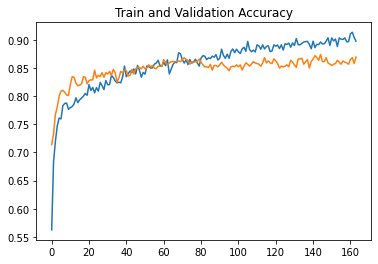

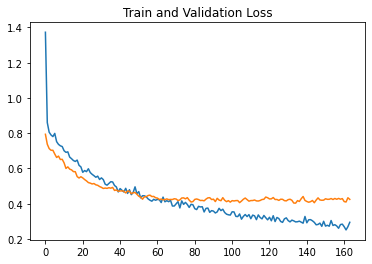

In [30]:
plot_results(history)

### Evaluate on the best model

In [31]:
best_model = load_best_model(checkpoint_filepath)
evaluate(best_model, test_generator)

28/28 [==============================] - 4s 144ms/step - loss: 0.4705 - accuracy: 0.8205
[0.47049880027770996, 0.8204833269119263]
